In [2]:

%pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from scipy import stats

plt.style.use("seaborn-v0_8")

Defaulting to user installation because normal site-packages is not writeable
  Using cached statsmodels-0.14.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00a 0:00:01
Using cached statsmodels-0.14.5-cp312-cp312-macosx_11_0_arm64.whl (9.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 1.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
circ = pd.read_csv("../data/circadian.csv")
barnes = pd.read_csv("../data/barnes.csv")

circ.head(), barnes.head()

(   ID  Sex  Age at Start (Month)   Age Group Light Group PRE/POST  Amplitude  \
 0   1  M                      29     Old-age         CNT     POST      2.861   
 1   1  M                      29     Old-age         CNT      PRE      2.777   
 2   2  M                      10  Middle-age         CNT     POST      2.945   
 3   2  M                      10  Middle-age         CNT      PRE      3.028   
 4   3  M                      10  Middle-age         ISF     POST      0.826   
 
    Period   Phase    Mean  % Variance   MESOR        F    p     RA     IV  \
 0      24  355.50   5.571       5.291   5.571  386.497  0.0  0.251  1.212   
 1      24   14.00   3.442       5.312   3.442  310.494  0.0  0.432  1.136   
 2      24   19.50   2.571       9.358   2.571  765.374  0.0  0.584  1.392   
 3      24    9.50   2.003       7.844   2.003  619.882  0.0  0.765  1.244   
 4      24  282.75  16.293       3.581  16.293  310.441  0.0  0.024  1.547   
 
       IS  
 0  0.292  
 1  0.405  
 2  0.

Clean circadian variable names and set types

In [10]:
circ.columns = [
    c.strip().replace(" ", "_").replace("%","pct").replace("/","_")
    for c in circ.columns
]

circ = circ.rename(columns={
    "Age_at_Start_(Month)": "AgeStart_month",
    "Age_Group": "AgeGroup",
    "Light_Group": "LightGroup",
    "PRE_POST": "PREPOST"
})

circ["ID"] = circ["ID"].astype("category")
circ["AgeGroup"] = circ["AgeGroup"].astype("category")
circ["LightGroup"] = circ["LightGroup"].astype("category")
circ["Sex"] = circ["Sex"].astype("category")
circ["PREPOST"] = circ["PREPOST"].astype("category")

circ.head()


,ID,Sex,AgeStart_month,AgeGroup,LightGroup,PREPOST,Amplitude,Period,Phase,Mean,pct_Variance,MESOR,F,p,RA,IV,IS
0,1,M,29,Old-age,CNT,POST,2.861,24,355.50,5.571,5.291,5.571,386.497,0.0,0.251,1.212,0.292
1,1,M,29,Old-age,CNT,PRE,2.777,24,14.00,3.442,5.312,3.442,310.494,0.0,0.432,1.136,0.405
2,2,M,10,Middle-age,CNT,POST,2.945,24,19.50,2.571,9.358,2.571,765.374,0.0,0.584,1.392,0.508
3,2,M,10,Middle-age,CNT,PRE,3.028,24,9.50,2.003,7.844,2.003,619.882,0.0,0.765,1.244,0.578
4,3,M,10,Middle-age,ISF,POST,0.826,24,282.75,16.293,3.581,16.293,310.441,0.0,0.024,1.547,0.333


Summarize circadian metrics by group

In [12]:
circ["LightGroup"].unique()


['CNT', 'ISF', 'CNT ']
Categories (3, object): ['CNT', 'CNT ', 'ISF']

In [13]:
circ["LightGroup"] = circ["LightGroup"].astype(str).str.strip().str.upper()
circ["LightGroup"].unique()

array(['CNT', 'ISF'], dtype=object)

In [14]:
summary_circ = circ.groupby(["LightGroup","PREPOST"])[
    ["RA","IV","IS","Amplitude","Mean","MESOR"]
].agg(["mean","std","count"])

summary_circ


/var/folders/t3/h94sjlkj52n5m4ht71d3mwmw0000gn/T/ipykernel_36235/461146929.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_circ = circ.groupby(["LightGroup","PREPOST"])[


RA                        IV                  \
                        mean       std count      mean       std count   
LightGroup PREPOST                                                       
CNT        POST     0.511184  0.240910    49  1.169531  0.289847    49   
           PRE      0.560306  0.259671    49  1.187735  0.302557    49   
ISF        POST     0.537067  0.223222    45  1.162444  0.307048    45   
           PRE      0.600432  0.244681    44  1.104318  0.293507    44   

                          IS                 Amplitude                  \
                        mean       std count      mean       std count   
LightGroup PREPOST                                                       
CNT        POST     0.461959  0.184297    49  2.987673  1.652745    49   
           PRE      0.482755  0.160412    49  3.167061  1.526152    49   
ISF        POST     0.510289  0.132498    45  3.267133  1.270034    45   
           PRE      0.529045  0.163233    44  3.274068  1.285222    44   

                        Mean                     MESOR                  
                        mean       std count      mean       std count  
LightGroup PREPOST                                                      
CNT        POST     4.456490  4.182293    49  4.456490  4.182293    49  
           PRE      4.483306  4.232846    49  4.483306  4.232846    49  
ISF        POST     4.153511  4.019262    45  4.153511  4.019262    45  
           PRE      4.120159  4.103097    44  4.120159  4.103097    44

Helper function to fit Mixed-Effects LMMs

In [15]:
def fit_mixed(formula, df, group, name):
    print(f"\n========== MODEL: {name} ==========")
    try:
        model = smf.mixedlm(formula, df, groups=df[group])
        res = model.fit(reml=False, method="lbfgs", maxiter=500, disp=False)
        print(res.summary())
        return res
    except Exception as e:
        print(f"Model for {name} failed:\n{e}")
        return None


Run circadian mixed-effects models

In [16]:
res_ra = fit_mixed("RA ~ LightGroup * PREPOST + AgeGroup + Sex",
                   circ, "ID", "RA")

res_iv = fit_mixed("IV ~ LightGroup * PREPOST + AgeGroup + Sex",
                   circ, "ID", "IV")

res_is = fit_mixed("IS ~ LightGroup * PREPOST + AgeGroup + Sex",
                   circ, "ID", "IS")



========== MODEL: RA ==========
                   Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        RA     
No. Observations:         187            Method:                    ML     
No. Groups:               94             Scale:                     0.0127 
Min. group size:          1              Log-Likelihood:            55.2418
Max. group size:          2              Converged:                 Yes    
Mean group size:          2.0                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.635    0.110  5.762 0.000  0.419  0.851
LightGroup[T.ISF]                 0.020    0.045  0.445 0.656 -0.068  0.109
PREPOST[T.PRE]                    0.049    0.023  2.154 0.031  0.004  0.09

/Users/carolinalangaro/Library/Python/3.12/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


Diagnostic plots

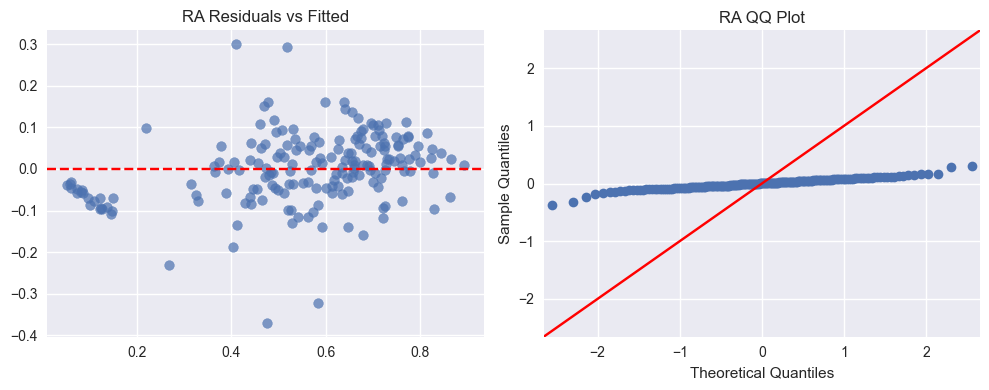

<Figure size 800x550 with 0 Axes>

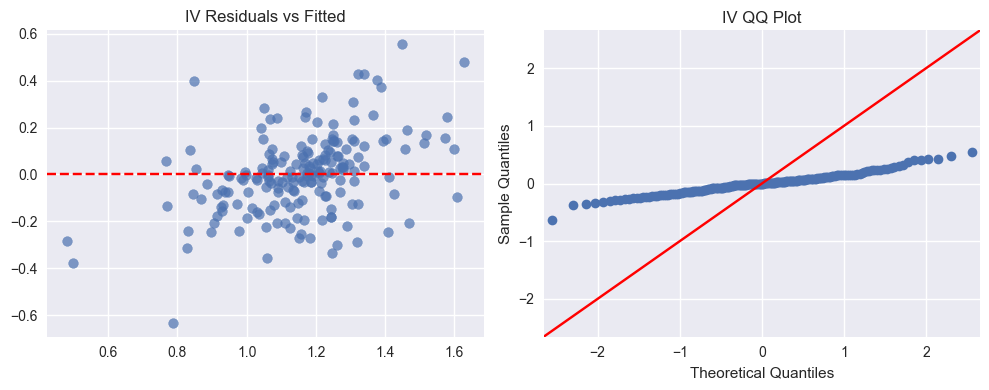

<Figure size 800x550 with 0 Axes>

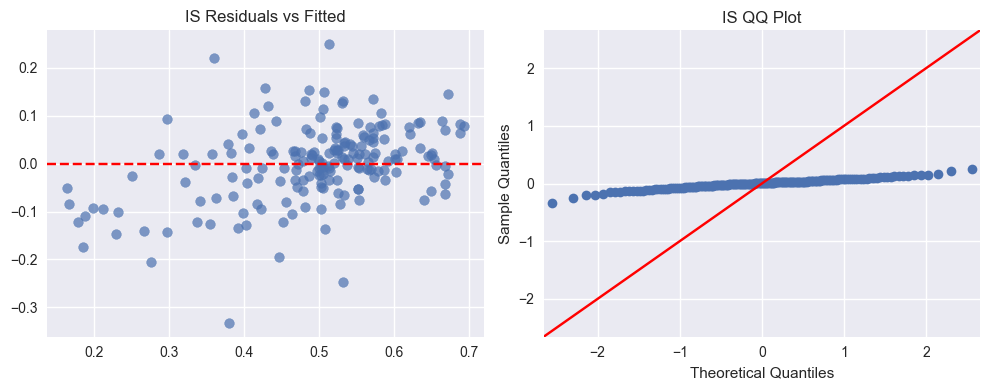

<Figure size 800x550 with 0 Axes>

In [30]:
def diagnostic_plots(res, varname):
    if res is None:
        return
    
    resid = res.resid
    fitted = res.fittedvalues

    fig, axes = plt.subplots(1,2,figsize=(10,4))

    axes[0].scatter(fitted, resid, alpha=0.7)
    axes[0].axhline(0, color="red", linestyle="--")
    axes[0].set_title(f"{varname} Residuals vs Fitted")

    sm.qqplot(resid, line="45", ax=axes[1])
    axes[1].set_title(f"{varname} QQ Plot")

    plt.tight_layout()
    plt.show()

diagnostic_plots(res_ra, "RA")
plt.savefig("../figures/diagnostic_plot_RA.png", dpi=300, bbox_inches="tight")
diagnostic_plots(res_iv, "IV")
plt.savefig("../figures/diagnostic_plot_IV.png", dpi=300, bbox_inches="tight")
diagnostic_plots(res_is, "IS")
plt.savefig("../figures/diagnostic_plot_IS.png", dpi=300, bbox_inches="tight")



Circular phase analysis

In [18]:
circ["Phase_rad"] = np.deg2rad(circ["Phase"])

phase_summary = circ.groupby(["ID","LightGroup","PREPOST"])["Phase_rad"].apply(
    lambda x: np.angle(np.mean(np.exp(1j*x)))
).reset_index(name="Phase_mean")

phase_wide = phase_summary.pivot(
    index=["ID","LightGroup"], columns="PREPOST", values="Phase_mean"
).dropna()

phase_wide["Phase_shift"] = np.angle(
    np.exp(1j*(phase_wide["POST"] - phase_wide["PRE"]))
)

phase_wide.groupby("LightGroup")["Phase_shift"].agg(["mean","std","count"])


/var/folders/t3/h94sjlkj52n5m4ht71d3mwmw0000gn/T/ipykernel_36235/2794785419.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phase_summary = circ.groupby(["ID","LightGroup","PREPOST"])["Phase_rad"].apply(


,mean,std,count
LightGroup,,,
CNT,-0.003295,0.479709,49
ISF,-0.056426,0.638420,44


Mann–Whitney on phase shifts

In [19]:
groups = [g["Phase_shift"].values for _,g in phase_wide.groupby("LightGroup")]
if len(groups) == 2:
    u, p = stats.mannwhitneyu(groups[0], groups[1])
    print("Mann–Whitney U test on phase shifts:", u, p)


Mann–Whitney U test on phase shifts: 1031.5 0.7233612599521817


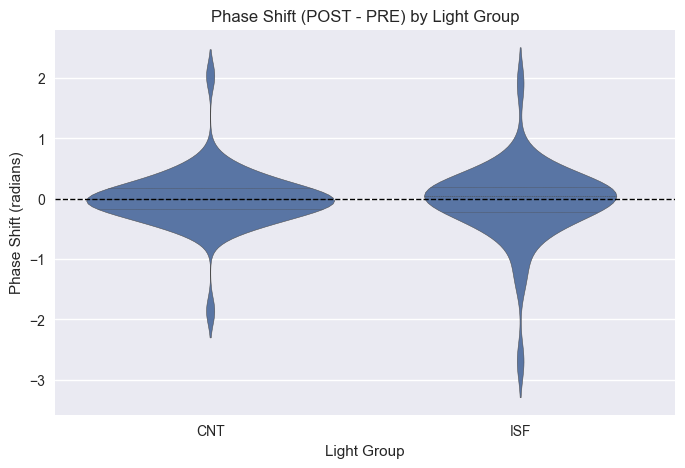

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.violinplot(data=phase_wide, x="LightGroup", y="Phase_shift", inner="quartile")
plt.title("Phase Shift (POST - PRE) by Light Group")
plt.xlabel("Light Group")
plt.ylabel("Phase Shift (radians)")
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.savefig("../figures/phase_shift_violin.png", dpi=300, bbox_inches="tight")
plt.show()

Clean Barnes Maze dataset

In [22]:
# Clean column names
barnes.columns = [
    c.strip().replace(" ", "_").replace("/", "_").replace("%","pct")
    for c in barnes.columns
]

# Cast categories
barnes["ID"] = barnes["ID"].astype("category")
barnes["Light"] = barnes["Light"].astype("category")
barnes["Sex"] = barnes["Sex"].astype("category")

# Force Age into numeric (coerce errors)
barnes["Age"] = pd.to_numeric(barnes["Age"], errors="coerce")

# ---- FIX ENTRY_LATENCY: convert everything to numeric first ----
barnes["Entry_latency"] = pd.to_numeric(barnes["Entry_latency"], errors="coerce")

# ---- NOW do log transform safely ----
barnes["log_latency"] = np.log(barnes["Entry_latency"].replace(0, np.nan))

# Fix Trial column
try:
    barnes["Trial_num"] = pd.to_numeric(barnes["Trial"], errors="coerce")
except:
    barnes["Trial_num"] = barnes["Trial"].astype("category").cat.codes

# Drop missing rows
bm_lat = barnes.dropna(subset=["log_latency"])

bm_lat.head()


,Trial,ID,Sex,Light,Age,EntryZone_nose_freq,Entry_latency,Goal_Box_0_Goal_Box___Center0point_0_Frequency,Goal_Box_0_Goal_Box___Center0point_0_Latency_to_First_(s),Target_visit_errors_0_Nose0point___Total_errors_0_Frequency,Quadrants_0_Q1___Center0point_0_Cumulative_Duration_(pct),Quadrants_0_Q2___Center0point_0_Q2___Center0point_(pct),Quadrants_0_Q3___Center0point_0_Cumulative_Duration_(pct),Quadrants_0_Q4___Center0point_0_Q4___Center0point_(pct),DistanceMoved_cm,log_latency,Trial_num
0,1,1,1,1,2,5,136.9000,1,157.1,19,14.3561,27.7264,27.6648,27.4184,1386.960,4.919251,1
1,2,1,1,1,2,1,128.1990,0,-,13,30.3977,23.2955,20.8807,19.9574,1271.130,4.853584,2
2,3,1,1,1,2,5,132.1990,1,137.799,25,27.2028,11.8881,30.1399,29.0210,1468.400,4.884308,3
3,4,1,1,1,2,1,123.8000,0,-,2,11.0599,29.1639,18.8282,27.5839,521.888,4.818667,4
4,5,1,1,1,2,3,30.7999,0,-,19,22.5948,12.1720,27.9155,36.4431,1002.910,3.427511,5


Mixed-effects model for Barnes latency

In [23]:
res_lat = fit_mixed(
    "log_latency ~ Light * Trial_num + Age + Sex",
    bm_lat,
    "ID",
    "Barnes Maze Latency"
)



========== MODEL: Barnes Maze Latency ==========
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   log_latency
No. Observations:   487       Method:               ML         
No. Groups:         90        Scale:                1.1281     
Min. group size:    2         Log-Likelihood:       -751.9180  
Max. group size:    6         Converged:            Yes        
Mean group size:    5.4                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             3.783    0.251 15.093 0.000  3.292  4.275
Light[T.2]            0.091    0.240  0.378 0.705 -0.380  0.561
Sex[T.2]             -0.408    0.138 -2.956 0.003 -0.678 -0.137
Trial_num            -0.140    0.041 -3.387 0.001 -0.220 -0.059
Light[T.2]:Trial_num -0.054    0.057 -0.947 0.343 -0.166  0.058
Age

/Users/carolinalangaro/Library/Python/3.12/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


FDR correction across all key hypotheses

In [26]:
print("\n=== RA MODEL TERMS ===")
print(res_ra.pvalues.index.tolist())

print("\n=== IV MODEL TERMS ===")
print(res_iv.pvalues.index.tolist())

print("\n=== IS MODEL TERMS ===")
print(res_is.pvalues.index.tolist())

print("\n=== Barnes MODEL TERMS ===")
print(res_lat.pvalues.index.tolist())



=== RA MODEL TERMS ===
['Intercept', 'LightGroup[T.ISF]', 'PREPOST[T.PRE]', 'AgeGroup[T.Old-age]', 'AgeGroup[T.Young]', 'Sex[T.F  ]', 'Sex[T.M  ]', 'LightGroup[T.ISF]:PREPOST[T.PRE]', 'Group Var']

=== IV MODEL TERMS ===
['Intercept', 'LightGroup[T.ISF]', 'PREPOST[T.PRE]', 'AgeGroup[T.Old-age]', 'AgeGroup[T.Young]', 'Sex[T.F  ]', 'Sex[T.M  ]', 'LightGroup[T.ISF]:PREPOST[T.PRE]', 'Group Var']

=== IS MODEL TERMS ===
['Intercept', 'LightGroup[T.ISF]', 'PREPOST[T.PRE]', 'AgeGroup[T.Old-age]', 'AgeGroup[T.Young]', 'Sex[T.F  ]', 'Sex[T.M  ]', 'LightGroup[T.ISF]:PREPOST[T.PRE]', 'Group Var']

=== Barnes MODEL TERMS ===
['Intercept', 'Light[T.2]', 'Sex[T.2]', 'Trial_num', 'Light[T.2]:Trial_num', 'Age', 'Group Var']


In [27]:
pvals = {}

# Pull circadian interaction terms
if "LightGroup[T.ISF]:PREPOST[T.PRE]" in res_ra.pvalues.index:
    pvals["RA interaction"] = res_ra.pvalues["LightGroup[T.ISF]:PREPOST[T.PRE]"]

if "LightGroup[T.ISF]:PREPOST[T.PRE]" in res_iv.pvalues.index:
    pvals["IV interaction"] = res_iv.pvalues["LightGroup[T.ISF]:PREPOST[T.PRE]"]

if "LightGroup[T.ISF]:PREPOST[T.PRE]" in res_is.pvalues.index:
    pvals["IS interaction"] = res_is.pvalues["LightGroup[T.ISF]:PREPOST[T.PRE]"]

# Pull Barnes interaction term
if "Light[T.2]:Trial_num" in res_lat.pvalues.index:
    pvals["Barnes latency interaction"] = res_lat.pvalues["Light[T.2]:Trial_num"]

# Handle empty dictionary case
if len(pvals) == 0:
    print("No p-values found — check model terms.")
else:
    print("Raw p-values:", pvals)
    adj = multipletests(list(pvals.values()), method="fdr_bh")
    print("FDR-adjusted p-values:", adj[1])


Raw p-values: {'RA interaction': np.float64(0.6090115745828898), 'IV interaction': np.float64(0.19185826269367934), 'IS interaction': np.float64(0.9570868972148439), 'Barnes latency interaction': np.float64(0.3434426075954895)}
FDR-adjusted p-values: [0.81201543 0.68688522 0.9570869  0.68688522]


Effect size example: Cohen's d for amplitude change

In [28]:
circ_wide = circ.pivot_table(
    index=["ID","LightGroup"],
    columns="PREPOST",
    values="Amplitude"
).dropna()

circ_wide["DeltaAmp"] = circ_wide["POST"] - circ_wide["PRE"]

grp = circ_wide.groupby("LightGroup")["DeltaAmp"]

mean_diff = grp.mean().diff().iloc[-1]
pooled_sd = np.sqrt(((grp.count() - 1) * grp.var()).sum() / (grp.count().sum() - 2))

cohens_d = mean_diff / pooled_sd
cohens_d


/var/folders/t3/h94sjlkj52n5m4ht71d3mwmw0000gn/T/ipykernel_36235/1018634201.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  circ_wide = circ.pivot_table(


np.float64(0.15631700266791748)